In [14]:
import pandas as pd
import SimpleITK as sitk
from radiomics import featureextractor
from radiomics.imageoperations import getWaveletImage, getLoGImage
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from hdbscan import HDBSCAN, approximate_predict
from scipy import ndimage
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics.pairwise import euclidean_distances
from skimage.morphology import binary_closing, binary_opening, binary_dilation, binary_erosion, remove_small_objects
import numpy as np
from matplotlib import pyplot as plt
import joblib
import json
import os
import cv2


In [15]:
def extract_radiomics_features(image, segmentation, case_info, saveWavletImages = False):
    """
    Extract radiomics features from an image and its segmentation.

    Parameters
    ----------
    image_path : str
        The path to the image file.
    segmentation_path : str
        The path to the segmentation file.

    Returns
    -------
    dict
        A dictionary containing the extracted features.
    """
    
    # Define the settings for the feature extractor
    settings = {}
    settings['binWidth'] = 25
    settings['resampledPixelSpacing'] = None  # [3,3,3] is an example for defining resampling (voxels with size 3x3x3mm)
    settings['interpolator'] = sitk.sitkBSpline
    settings['Label'] = 1
    # settings['imageType'] = {'Original': {}, 'LoG': {'sigma': [1.0, 3.0]}, 'Wavelet': {'binWidth': 25}}
    # settings['featureClass'] = {'firstorder': {}, 'shape2D': {}, 'glcm': {}, 'glrlm': {}, 'glszm': {}, 'ngtdm': {}, 'gldm': {}}
    settings['additionalInfo'] = False
    
    # Initialize the feature extractor
    extractor = featureextractor.RadiomicsFeatureExtractor(**settings)

    # Enable the desired features
    # extractor.enableAllFeatures()
    extractor.enableFeatureClassByName('shape2D')
    extractor.enableImageTypes(Original={}, Wavelet={'binWidth': 10})
    
    #extract from each segmentaion connected components and extract features from each connected component
    # Find connected components
    num_labels, labels = cv2.connectedComponents(sitk.GetArrayFromImage(segmentation).astype(np.uint8))
    # Initialize lists to store shape information
    features_df = pd.DataFrame()
    # Iterate over each connected component
    for label in range(1, num_labels):
        try:
            # Create a mask for the current component
            label_array = np.uint8(labels == label)
            mask = sitk.GetImageFromArray(label_array)
            # sitk.WriteImage(mask*255, os.path.join('/home/benito/script/NephroBIT/KPIs24/post_processing/masks', f'{segmentation_path.split('/')[-1].split('.jpg')[0]}_mask_label{label}.png'))
            #extract features
            features = pd.Series(extractor.execute(image, mask)).to_frame().T
            features_names = features.columns.tolist()
            features_values = features.values.tolist()[0]
            
            features_names = ["id", "class", "id_patch", "n_foreground_pixels", *features_names]
            features_values = [case_info['mask'].split('/')[-3], case_info['mask'].split('/')[-4], case_info['mask'].split('/')[-1].split(".jpg")[0] + f"_{label}", label_array.sum() ,*features_values]
            
            features = pd.DataFrame([features_values], columns=features_names)
            
            #join the features of the connected components to the features of the entire image
            features_df = pd.concat([features_df, features], axis = 0)
        except:
            print(f"Error in extracting features from connected component {label}")
            continue
                 
    return features_df

In [16]:
#image data path 
datapath = '/mnt/atlas/data_KPIs/data/KPIs24_Training_Data/Task1_patch_level/split/'

#segmentation data path
segmentationpath = '/home/benito/script/KPIs24/results/3foldCV/SwinUNETR/CropPosNeg/fold_0/validation/constant_windowing/TTA/predicted_masks_fold0'

#train
val_fold = 0

#define parameters
#load pkl cluster model file
cluster_model = joblib.load('/home/benito/script/NephroBIT/KPIs24/notebooks/cluster_train_radiomics.pkl')
reduction_model = joblib.load('/home/benito/script/NephroBIT/KPIs24/notebooks/pca_train_radiomics.pkl')

#load norm from json file
with open('/home/benito/script/NephroBIT/KPIs24/notebooks/mean_std_train_radiomics.json', 'r') as file:
    normalization_method = json.load(file) 

#get train and test data from json file
# Specify the file path
nfolds = 3
for i in range(nfolds):
    if i == val_fold:
        file_path = f'/home/benito/script/NephroBIT/split_json/fold_{i}.json'
        with open(file_path, 'r') as file:
            split = json.load(file)
        if val_fold == i:
            patients_val = np.unique([case['case_id'] for case in split['cases']])
            
patients_val = patients_val[0:10]

In [17]:
case=  split['cases'][0]
image_path = case['img']


(-0.5, 2047.5, 2047.5, -0.5)

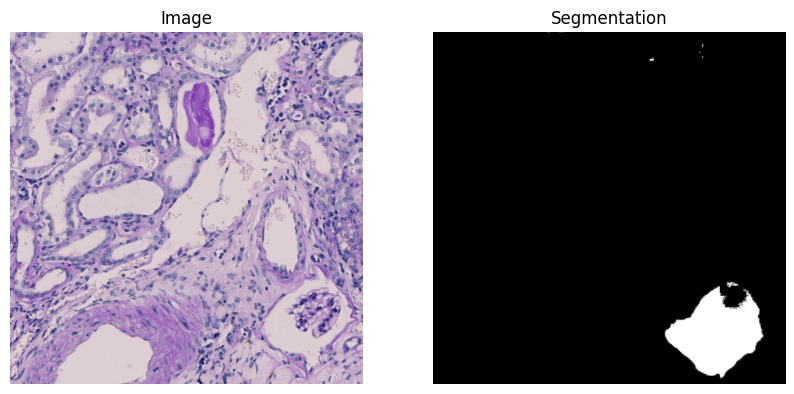

In [18]:
case=  split['cases'][0]
image_path = case['img']
segmentation_path = os.path.join(segmentationpath, case['mask'].split('/')[-1].split('.jpg')[0] + '.jpg')
# Load the image and segmentation using SimpleITK
image = sitk.ReadImage(image_path)
image_int = sitk.ReadImage(image_path, sitk.sitkInt8)
segmentation = sitk.ReadImage(segmentation_path)
#set the label value for the segmentation to 1 (the label value of the ROI) instead of 255
segmentation = sitk.BinaryThreshold(segmentation, 0, 0, 0, 1)
#show the image and the segmentation in the same plot
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(sitk.GetArrayFromImage(image).squeeze())
plt.title('Image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(sitk.GetArrayFromImage(segmentation).squeeze(), cmap='gray')
plt.title('Segmentation')
plt.axis('off')

In [44]:
seg_post = binary_closing(sitk.GetArrayFromImage(segmentation)).astype(int)
seg_post = ndimage.binary_fill_holes(seg_post, structure = np.ones((200,200))).astype(int)
# seg_post = ndimage.binary_fill_holes(sitk.GetArrayFromImage(segmentation), structure = np.ones((200,200))).astype(int)

In [ ]:
#resize the image to lower size, fill holes and then resize back to original size
image_resized = sitk.Resample(image_int, seg_post.shape, sitk.Transform(), sitk.sitkNearestNeighbor, image_int.GetOrigin(), image_int.GetSpacing(), image_int.GetDirection(), 0.0, image_int.GetPixelID())
image_resized = sitk.Cast(image_resized, sitk.sitkInt8)
image_resized = sitk.BinaryThreshold(image_resized, 0, 0, 0, 1)
image_resized = sitk.GetArrayFromImage(image_resized)
image_resized = image_resized.squeeze()
image_resized = ndimage.binary_fill_holes(image_resized, structure = np.ones((5,5))).astype(int)
image_resized = sitk.GetImageFromArray(image_resized)

In [36]:
seg_post.shape

(2048, 2048)

(-0.5, 2047.5, 2047.5, -0.5)

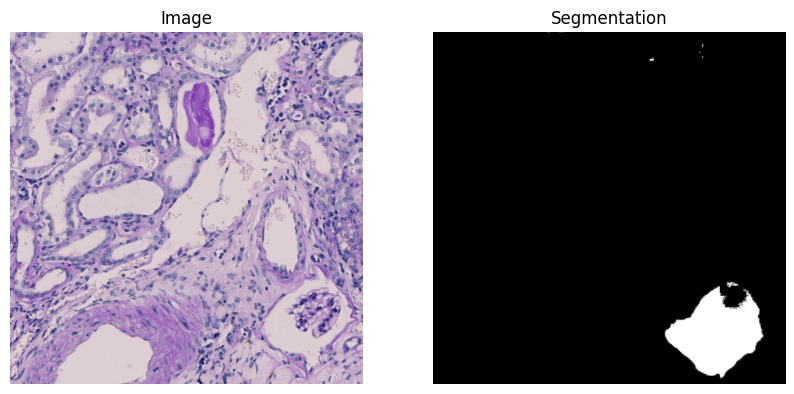

In [41]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(sitk.GetArrayFromImage(image).squeeze())
plt.title('Image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(seg_post, cmap='gray')
plt.title('Segmentation')
plt.axis('off')

In [49]:
segmentation_postprocessed = remove_small_objects(sitk.GetArrayFromImage(segmentation).astype(bool), min_size=200).astype(np.uint8)
#apply closing operation
segmentation_postprocessed = binary_closing(segmentation_postprocessed, np.ones((5,5))).astype(np.uint8)


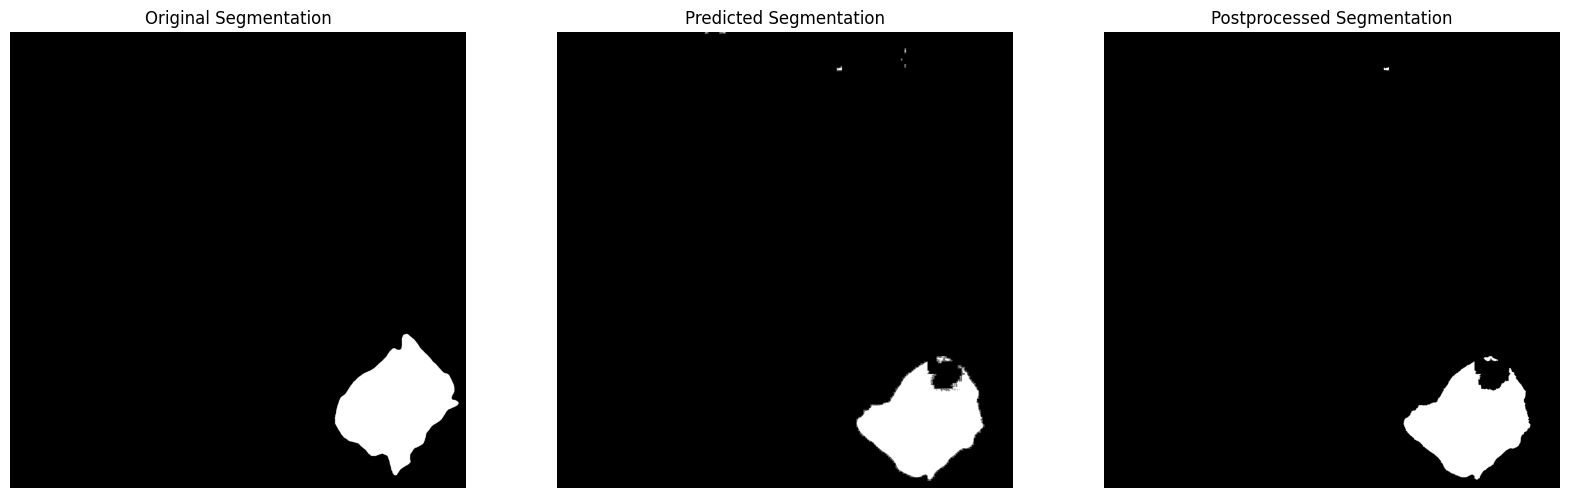

In [51]:
#show in the same subplot the original and postprocessed segmentation
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(sitk.GetArrayFromImage(sitk.ReadImage(case['mask'])), cmap='gray')
plt.title('Original Segmentation')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(sitk.GetArrayFromImage(segmentation), cmap='gray')
plt.title('Predicted Segmentation')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(segmentation_postprocessed, cmap='gray')
plt.title('Postprocessed Segmentation')
plt.axis('off')
plt.show()


In [73]:
segmentation = segmentation_postprocessed
features = extract_radiomics_features(image, segmentation, case , saveWavletImages = False)

Error in extracting features from connected component 1
Error in extracting features from connected component 2
Error in extracting features from connected component 3


In [ ]:
#extract features from the validation set
features_val = pd.DataFrame()
features_val_pca = pd.DataFrame()
cluster_val = pd.DataFrame()
for patient in patients_val:
    for case in split['cases']:
        if case['case_id'] == patient:
            image_path = case['img']
            segmentation_path = os.path.join(segmentationpath, case['mask'].split('/')[-1].split('.jpg')[0] + '.jpg')
            features = extract_radiomics_features(image_path, segmentation_path, saveWavletImages = False)
            #read the features and their normalization value (mean and std) from the normalization normalization_method dictionary and normalize the features
            #first select only the features that are in the dictonary
            columns = normalization_method.keys()
            features = features[columns]
            for feature in features.columns:
                    features[feature] = (features[feature] - normalization_method[feature]['mean']) / normalization_method[feature]['std']  
            #apply pca and clustering
            features_pca = reduction_model.transform(features)
            cluster = cluster_model.predict(features)
            
            features_val_pca = pd.concat([features_val_pca, pd.DataFrame(features_pca, columns = [f'pca_{i}' for i in range(features_pca.shape[1])])], axis = 0)
            cluster_val = pd.concat([cluster_val, pd.DataFrame(cluster, columns = ['cluster'])], axis = 0)
            features_val = pd.concat([features_val, features], axis = 0)
            #pause to check the results
            print(f"Patient {patient} features extracted")
            break

In [ ]:
# Train the model
train_data, dimensionality_reduction_model, cluster_model = pca_clustering(df_train_norm.iloc[:,3:], method_reduction=reduction_method, n_components=2, method_cluster = cluster_method, n_clusters=n_clusters)
# test_data(df_test, dimensionality_reduction_model, cluster_model)

In [ ]:
df_train_data = df_train.iloc[:,:3]
df_train_data.reset_index(drop=True, inplace=True)
df_train_data = pd.concat([df_train_data, pd.DataFrame(train_data, columns=['pca1', 'pca2'])], axis=1)
#associate to each point its cluster calculated with the cluster model
df_train_data['cluster'] = cluster_model.labels_

In [ ]:
### scatter plot stratiying by class
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot()

colors = ['blue', 'red', 'green', 'black']
for i, class_glom in enumerate(df_train_data['class'].unique()):
    ax.scatter(df_train_data[df_train_data['class'] == class_glom]['pca1'], df_train_data[df_train_data['class'] == class_glom]['pca2'], c=colors[i], label=f'class {class_glom}', s=0.5)
    #add axis labels to the plot
ax.set_xlabel(f'PCA1 - explained variance: {dimensionality_reduction_model.explained_variance_ratio_[0]:.2f}')
ax.set_ylabel(f'PCA2 - explained variance: {dimensionality_reduction_model.explained_variance_ratio_[1]:.2f}')
# ax.set_zlabel(f'PCA3 - explained variance: {dimensionality_reduction_model.explained_variance_ratio_[2]:.2f}')
ax.legend()
plt.show()


In [ ]:
from matplotlib import cm
### scatter plot stratiying by cluster
fig, ax = plt.subplots(figsize=(10, 10))
# colors = ['blue', 'red', 'green', 'black']

colors = (['black'] + list(cm.tab10(np.linspace(0, 1, df_train_data['cluster'].unique().shape[0] -1)))  if 'dbscan' in cluster_method  else  ['blue', 'red', 'green', 'black', 'gray', 'purple'])

for i, cluster in enumerate(sorted(df_train_data['cluster'].unique())):
    ax.scatter(df_train_data[df_train_data['cluster'] == cluster]['pca1'], df_train_data[df_train_data['cluster'] == cluster]['pca2'], c=colors[i], label=f'cluster {cluster}', s=(1 if cluster == -1 else 10))
ax.legend()

if cluster_method == 'kmeans':
    for i, cluster in enumerate(cluster_model.cluster_centers_):
        ax.scatter(cluster[0], cluster[1], c='violet', s=10)
        plt.annotate(f'cluster {i}', (cluster[0], cluster[1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=15)
plt.show()


In [ ]:
#calculate the distance of the test data to the cluster centers
closest_cluster, distances_values = pairwise_distances_argmin_min(train_data, cluster_model.cluster_centers_)
print(f'CLOSEST CLUSTER: {closest_cluster}' )
print(f'DISTANCES BETWEEN CLUSTERS CENTERS: {distances_values}')
distances_train_df = pd.DataFrame()
distances_train_df['id'] = df_train_data['id']
distances_train_df['class'] = df_train_data['class']
distances_train_df['id_patch'] = df_train_data['id_patch']
distances_train_df['distance'] = distances_values
distances_train_df['cluster'] = df_train_data['cluster']
distances_train_df['pca1'] = df_train_data['pca1']
distances_train_df['pca2'] = df_train_data['pca2']
distances_train_df.describe()


In [ ]:
#clusters identified by kmeans
if cluster_method == 'kmeans':
    dists_clusters = euclidean_distances(cluster_model.cluster_centers_)
    print(f'DISTANCE BETWEEN CLUSTERS: {dists_clusters}')

In [ ]:
# Apply dimensionality reduction to test data
test_pca = dimensionality_reduction_model.transform(df_test_norm.iloc[:,3:])
df_test_pca = df_test.iloc[:,:3]
df_test_pca.reset_index(drop=True, inplace=True)
df_test_pca = pd.concat([df_test_pca, pd.DataFrame(test_pca, columns=['pca1', 'pca2'])], axis=1)
if cluster_method == 'hdbscan':
    predictions = approximate_predict(cluster_model, test_pca)
    df_test_pca['cluster'] = predictions[0]
    df_test_pca['probabilty_cluster'] = predictions[1]
elif cluster_method == 'kmeans':
    df_test_pca['cluster'] = cluster_model.predict(test_pca)
else:
    raise Exception('Invalid cluster method or predict not implemented!')

# Check if the data belong to one of the clusters defined by the model
# cluster_centers = cluster_model.cluster_centers_
# print(f'TRAIN CLUSTERS CENTER: {cluster_centers}')
# print(f'TRAIN CLUSTER LABELS: {np.unique(cluster_model.labels_)}')

# distances = euclidean_distances(df_test_pca[['pca1', 'pca2']], cluster_model.cluster_centers_)

# #calculate the distance of the test data to the cluster centers
# # closest_cluster, distances = pairwise_distances_argmin_min(reduced_test_data, cluster_centers)
# # print(f'CLOSEST CLUSTER: {closest_cluster}' )
# print(f'DISTANCES BETWEEN CLUSTERS CENTERS: {distances}')
# distances = pd.DataFrame(distances)
# distances.describe()

In [ ]:
### scatter plot stratiying by class
fig, ax = plt.subplots()
colors = ['blue', 'red', 'green', 'black']
for i, class_glom in enumerate(sorted(df_test_pca['class'].unique())):
    ax.scatter(df_test_pca[df_test_pca['class'] == class_glom]['pca1'], df_test_pca[df_test_pca['class'] == class_glom]['pca2'], c=colors[i], label=f'class {class_glom}', s=1)
    # ax.set_xlim(-2, 2)  # Set x-axis limits
ax.legend()

plt.show()


In [ ]:
### scatter plot stratiying by cluster
fig, ax = plt.subplots()
colors = (['black'] + list(cm.tab10(np.linspace(0, 1, df_train_data['cluster'].unique().shape[0] -1)))  if 'dbscan' in cluster_method else  ['blue', 'red', 'green', 'black'])

for i, cluster in enumerate(sorted(df_test_pca['cluster'].unique())):
    ax.scatter(df_test_pca[df_test_pca['cluster'] == cluster]['pca1'], df_test_pca[df_test_pca['cluster'] == cluster]['pca2'], c=colors[i], label=f'cluster {cluster}', s=1)
ax.legend()
if cluster_method == 'kmeans':
    cluster_centers = cluster_model.cluster_centers_
    #add a point for each cluster
    for i, cluster in enumerate(cluster_centers):
        ax.scatter(cluster[0], cluster[1], c='violet', s=10)
        plt.annotate(f'cluster {i}', (cluster[0], cluster[1]), textcoords="offset points", xytext=(0,10), ha='center')
plt.show()


In [ ]:
### find point that are far from the cluster centers
distances = euclidean_distances(df_test_pca[['pca1', 'pca2']], cluster_model.cluster_centers_)


In [ ]:
#calculate the distance of the test data to the cluster centers
closest_cluster, distances_values = pairwise_distances_argmin_min(test_pca, cluster_model.cluster_centers_)
print(f'CLOSEST CLUSTER: {closest_cluster}' )
print(f'DISTANCES BETWEEN CLUSTERS CENTERS: {distances}')
distances_test_df = pd.DataFrame()
distances_test_df['id'] = df_test['id']
distances_test_df['class'] = df_test['class']
distances_test_df['id_patch'] = df_test['id_patch']
distances_test_df['distance'] = distances_values
distances_test_df['cluster'] = df_test_pca['cluster']
distances_test_df['pca1'] = df_test_pca['pca1']
distances_test_df['pca2'] = df_test_pca['pca2']
distances_test_df.describe()


In [ ]:
#histogram of distances to the cluster centers by class
fig, ax = plt.subplots()
for i, class_glom in enumerate(sorted(df_train_data['class'].unique())):
    ax.hist(distances_train_df[distances_train_df['class'] == class_glom]['distance'], bins=100, alpha=0.5, label=f'class {class_glom}')
ax.legend() 
plt.show()


In [ ]:
#histogram of distances to the cluster centers by class
fig, ax = plt.subplots()
for i, class_glom in enumerate(sorted(df_train_data['cluster'].unique())):
    ax.hist(distances_train_df[distances_train_df['cluster'] == class_glom]['distance'], bins=100, alpha=0.5, label=f'cluster {class_glom}')
ax.legend() 
plt.show()


In [ ]:
#histogram of distances to the cluster centers by class
fig, ax = plt.subplots()
for i, class_glom in enumerate(sorted(df_test_pca['class'].unique())):
    ax.hist(distances_test_df[distances_test_df['class'] == class_glom]['distance'], bins=100, alpha=0.5, label=f'class {class_glom}')
ax.legend() 
plt.show()


In [ ]:
#image to check: get the images with the highest distance to the cluster centers and check if they are outliers
distances_train_df.sort_values(by='distance', ascending=False, inplace=True)
distances_train_df.reset_index(drop=True, inplace=True)

#check the images with the highest distance to the cluster centers
df_train_outliers = distances_train_df.head(10)

#scatter plot of the outliers
fig, ax = plt.subplots()
colors = ['blue', 'red', 'green', 'black']
for i, class_glom in enumerate(sorted(df_train_outliers['class'].unique())):
    ax.scatter(df_train_outliers[df_train_outliers['class'] == class_glom]['pca1'], df_train_outliers[df_train_outliers['class'] == class_glom]['pca2'], c=colors[i], label=f'class {class_glom}', s=1)
    # ax.set_xlim(-2, 2)  # Set x-axis limits
ax.legend()
plt.show()



In [ ]:
#load and plot image and mask in the same subplot for all the outliers in the test set
for i, row in df_train_outliers.iterrows():
    image_path = os.path.join(datapath, row['class'], row['id'], 'img', row['id_patch'].split('_mask')[0] + '_img.jpg')
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask_path = os.path.join(datapath, row['class'], row['id'], 'mask', row['id_patch'].split('_mask')[0] + '_mask.jpg')
    mask = cv2.imread(mask_path)
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    fig.suptitle(f'Class: {row["class"]}, ID: {row["id"]}, Patch ID: {row["id_patch"]}')
    ax[0].imshow(image)
    ax[1].imshow(mask)
    #tight layout
    plt.tight_layout()
    plt.show()
    
#mask data path


In [ ]:
#image to check: get the images with the highest distance to the cluster centers and check if they are outliers
distances_test_df.sort_values(by='distance', ascending=False, inplace=True)
distances_test_df.reset_index(drop=True, inplace=True)

#check the images with the highest distance to the cluster centers
df_test_outliers = distances_test_df.head(10)

#scatter plot of the outliers
fig, ax = plt.subplots()
colors = ['blue', 'red', 'green', 'black']
for i, class_glom in enumerate(sorted(df_test_outliers['class'].unique())):
    ax.scatter(df_test_outliers[df_test_outliers['class'] == class_glom]['pca1'], df_test_outliers[df_test_outliers['class'] == class_glom]['pca2'], c=colors[i], label=f'class {class_glom}', s=1)
    # ax.set_xlim(-2, 2)  # Set x-axis limits
ax.legend()
plt.show()



In [ ]:
#load and plot image and mask in the same subplot for all the outliers in the test set
for i, row in df_test_outliers.iterrows():
    image_path = os.path.join(datapath, row['class'], row['id'], 'img', row['id_patch'].split('_mask')[0] + '_img.jpg')
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask_path = os.path.join(datapath, row['class'], row['id'], 'mask', row['id_patch'].split('_mask')[0] + '_mask.jpg')
    mask = cv2.imread(mask_path)
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    fig.suptitle(f'Class: {row["class"]}, ID: {row["id"]}, Patch ID: {row["id_patch"]}')
    ax[0].imshow(image)
    ax[1].imshow(mask)
    #tight layout
    plt.tight_layout()
    plt.show()
    
#mask data path
